In [1]:
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import psutil
warnings.filterwarnings('ignore') #关闭警告信息
#在notebook中显示动态图像
%matplotlib notebook

In [2]:
Uf_effVal = 35. #故障时相电压有效值
U2f_effVal =10.
U3f_effVal =5.
knum = 5 #
If_effVal = 10
I2f_effVal =1
f = 50 #基频
fs = 1200 #采样频率
ts = 1.0/fs #采样时间
omega = 2*np.pi*f #基频 角频率
alpha = 0 #A相电压初相角 弧度值
Ialpha = alpha-10*np.pi/180
beta = 2*np.pi/3 #B相 初相角
theta = -2*np.pi/3 #C相 初相角
N = 24 # 每20ms采样个数（1200hz采样对对应24个点）

In [3]:
class FIR():
    def __init__(self):
        return
    
    def FreResponse(self):
        
        fig,ax1 = plt.subplots(figsize=(12,4))
        
        f1 = [1,0,0,0,0,0,-1]
        f2 = [1,1,1,1,1,1,1,1]
        f3 = [1,1,1,1,1,1,1,1,1,1]
        f4 = np.convolve(f1,f2)
        f = np.convolve(f4,f3)
        w,h = signal.freqz(f,worN=np.linspace(0,np.pi,1000))
        ax1.plot(1200*w/2/np.pi,(np.abs(h)),'b')
        ax1.grid()
        plt.show()
        return

    def Casca3FIR(self,samPoints):

        N1 = 6#
        N2 = 7#
        N3 = 9
        y1 = []
        y2 = []
        y = []
        for index in np.arange(0,len(samPoints)):
            if index >= N1:
                y1.append(samPoints[index]-samPoints[index-N1])
                if len(y1) >= (N2+1):
                    y2.append(sum(y1[-N2-1:]))
                    if len(y2) >= (N3+1):
                        y.append(sum(y2[-N3-1:]))
        yBase = np.array(y)/69.5
        return yBase

In [21]:
class EeFault(): 
    """
    由于发生故障时，采样得到的量并部满足正弦稳态情况
    因此 采用全波傅氏算法计算故障时基波的 实部 和 虚部
    值得注意的是，傅立叶算法同样是在计算 稳态正弦量
    也就是说，所求得的每一个复数是该频率下的 实部和虚部
    因此，当存在直流衰减分量时，该算法有极大误差，需要配合FIR滤波器（一阶差分）
    """
    def __init__(self):
        return
    
    def testPlot(self,x,y,type=1):
        #init plot
        self.fig = plt.figure()
        self.ax =self.fig.add_subplot(111)
        self.ax.set_autoscaley_on(True)
        self.ax.grid()
        if type == 1:
            #line
            self.ax.plot(x,y,color='b')
            self.ax.relim()
            self.ax.autoscale_view()
            self.ax.set_ylim(-600,800)
            self.fig.canvas.draw()
        elif type == 2:
            self.ax.bar(x,y,1.8,color='b')
            self.fig.canvas.draw()
            
    def FaultSam(self):
        """
        模拟故障时采样得到的值
        """
        uFault_sam = [] #电压采样值
        iFault_sam = [] #电流采样值
        tdata = [] #采样时间点
        for item,t in enumerate(np.arange(0,0.3,ts)):
            tdata.append(t)
            #叠加了不同频率的电压采样值
            sampTmpU = 5000*np.exp(-50*t) + \
                      Uf_effVal*np.sin(omega*t+alpha) + \
                      U2f_effVal*np.sin(2*omega*t+alpha+np.pi/3) + \
                      U3f_effVal*np.sin(3*omega*t+alpha+np.pi/2)
            #叠加了不同频率的电流采样值
            sampTmpI = 10 + \
                      1.414*If_effVal*np.sin(omega*t+Ialpha) + \
                      1.414*I2f_effVal*np.sin(2*omega*t+Ialpha-np.pi/3) 
            #每一个时刻t采样保存一个值         
            uFault_sam.append(sampTmpU) 
            iFault_sam.append(sampTmpI)
            
        self.testPlot(tdata,uFault_sam)
        return (tdata,uFault_sam,iFault_sam)
    
    def DealData(self,Npoints,type=1):
        
        kthFreq = np.arange(knum) # 需要计算的 频率个数
        Re = [0 for i in range(knum)] #用于存放不同频率下的 实部
        Img = [0 for i in range(knum)] #用于存放不同频率下的 实虚部
        Nsum = np.sum(Npoints[:N])
        N_evensum = np.sum([Npoints[even_index] for even_index in np.arange(N) if (even_index)%2==0])
        N_oddsum = Nsum-N_evensum
        if type == 1:
            #采用外循环为每一个点 内循环为每一中频率
            #为要模拟 采样的过程 即采样是一个点一点点得到的
            for index in np.arange(N):
                for k in kthFreq:
                    #采样得到一个点后 对所有谐波分量进行计算
                    Re[k] += (Npoints[index]*np.sin(k*index*2*np.pi/N))*2/N #用滤波后的值进行计算基频分量
                    Img[k] += (Npoints[index]*np.cos(k*index*2*np.pi/N))*2/N #如果想要观察滤波前，可将Yfilter替换为samPoint

            #将每一个谐波分量组合成复数
        elif type == 2:
            
            for k in kthFreq:
                for index in np.arange(N):
                    
                    Re[k] += (Npoints[index]*np.sin(k*index*2*np.pi/N))*2/N 
                    Img[k] += (Npoints[index]*np.cos(k*index*2*np.pi/N))*2/N
                
                B = N_oddsum/N_evensum
                A = (1-B)*Nsum
                fenziRe = 2*A*B*np.sin(k*2*np.pi/N)
                fenziImg = 2*A*(1-B*np.cos(k*2*np.pi/N))
                fenmu = (1-2*B*np.cos(k*2*np.pi/N)+np.power(B,2))*N
                deltaRe = fenziRe/fenmu
                deltaImg = fenziImg/fenmu
                Re[k] = Re[k] - deltaRe
                Img[k] = Img[k] - deltaImg
            
            """
            fenziRe = 2*A*B*np.sin(kindex*2*np.pi/N)
                fenziImg = 2*A*(1-B*np.cos(kindex*2*np.pi/N))
                fenmu = (1-2*B*np.cos(kindex*2*np.pi/N)+np.power(B,2))*N
                deltaRe = fenziRe/fenmu
                deltaImg = fenziImg/fenmu
                Re[kindex] = Re[kindex] - deltaRe
                Img[kindex] = Img[kindex] -deltaImg
            
            """
                
            
        
        return (Re,Img)
    
    def FullFourier(self,samPoint):
        """
        全波傅氏算法的核心
                   N-1
              2    ----
       Urk = --- * \
              N    /    u(i)*sin(ki*2pi/N)   
                   ----
                   i=0
                   
                   N-1
              2    ----
       Uik = --- * \
              N    /    u(i)*sin(ki*2pi/N)
                   ----
                   i=0
        k：k次谐波
        i：第i个时刻
        u(i)：第i个采样点
        N：一个周期的采样个数
        Urk：第k次谐波的 实部
        Uik：第k次谐波的 虚部
        """        
          
        knFreqReIm = [] #其内每一个值对应着 该频率下 正弦量的 复数形式 
        
        
        #调用滤波函数
        Fir = FIR() 
        #给定2N个采样值 前N个用于滤波 得到Yfilter大约是N个点
        Yfilter = Fir.Casca3FIR(samPoint[:2*N])
        
        (Re,Img) = self.DealData(samPoint,type=2)
        
        for re,imag in zip(Re,Img):
            knFreqReIm.append(np.complex(re,imag))
        
        return knFreqReIm
    
    def FaultSamReIm(self):
        """
        计算故障时 采样值中 不同频率下 正弦量的 实部和虚部
        有了故障时刻得到的 基频分量的 复数形式 
        接下来就可以进行 各种保护的 动作判据计算
        """
        #获得采样值
        (tdata,uFault_sam,iFault_sam) = self.FaultSam() #
        #求采样值中 不同频率 电压正弦量的 复数形式 该复数的模值为正弦量的 最大值
        UfnReIm = self.FullFourier(uFault_sam)
        #求采样值中 不同频率 电流正弦量的 复数形式
        IfnReIm = self.FullFourier(iFault_sam)
        
        x = (np.arange(knum))*f
        y = np.abs(UfnReIm)
        self.testPlot(x,y,type=2)
        
        return (UfnReIm,IfnReIm)
    
    def FaultImped(self,u,i):
        """
        通过给定故障时计算得到的 电压和电流的复数，求故障时的阻抗
            Ur*Ir+Ui*Ii
        R = -----------
             Ir^2+Ii^2
             
            Ui*Ir-Ur*Ii
        Q = -----------
             Ir^2+Ii^2
        """
        #阻抗
        Resis = (u.real*i.real+u.imag*i.imag)/(np.power(i.real,2)+np.power(i.imag,2))
        React = (u.imag*i.real-u.real*i.imag)/(np.power(i.real,2)+np.power(i.imag,2))
        imped = np.complex(Resis,React)
        return imped
    
    def DistancePro(self):
        """
        距离保护
        """
        #计算故障时不同频率正弦量的 复数形式
        UfnReIm,IfnReIm = self.FaultSamReIm()
        #计算故障时的基频分量阻抗值
        FaultImped = self.FaultImped(UfnReIm[1],IfnReIm[1])
        
        return

In [22]:
obj = EeFault()

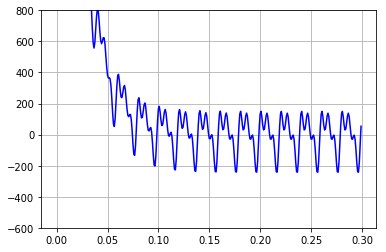

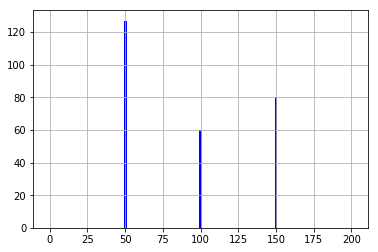

In [23]:
x = obj.FaultSamReIm()
#x = obj.FaultSam()

In [24]:
abs(x[0][1])

127.00000000000614

In [ ]:
(34+1)%2 ==1

In [ ]:
127*1.414

In [ ]:
60*1.414

In [ ]:
np.sum([1.,2.])

In [ ]:
[odd_index for odd_index in np.arange(N) if (odd_index+1)%2==1]

In [ ]:
0%2

In [ ]:
tdata = []
uFault_sam = []
for item,t in enumerate(np.arange(0,0.3,ts)):
    tdata.append(t)
    #叠加了不同频率的电压采样值
    sampTmpU = 10*np.exp(-50*t) #+ \
              #1.414*Uf_effVal*np.sin(omega*t+alpha) + \
              #1.414*U2f_effVal*np.sin(2*omega*t+alpha+np.pi/3) + \
              #1.414*U3f_effVal*np.sin(3*omega*t+alpha+np.pi/2)
   
    #每一个时刻t采样保存一个值         
    uFault_sam.append(sampTmpU) 
  
            
plt.figure(figsize=(8,4))
plt.plot(tdata,uFault_sam)
plt.show()